# Data Engineering

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import seaborn as sns
import matplotlib.pyplot as plt

import re
import time

import fundamentus

from google.cloud import storage
import os

import sys
sys.path.append('..')
from scripts.utils import initialize_bucket
import requests
import requests_cache
import logging
import time
from datetime import date

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

2023-06-08 12:15:59,235 [logging.log_init] INFO: LOGLEVEL=INFO


In [2]:
pd.set_option("display.max_columns", 200)

In [3]:
credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

## 1 - Data Collection

For the data gathering, two repositories on Github were combined, so that the historical data could be scraped from the web. This Raw data is beeing stored in the cloud (GCP) and are the main data used for the project.

Repositories utilized:
* https://github.com/mv/fundamentus-api
* https://github.com/Victorcorcos/bovespa-winner

In [4]:
def perc_to_float(val):
    """
    Percent to float
      - replace string in pt-br to float
      - from '45,56%' to 0.4556
    Input:
        (DataFrame, column_name)
    """

    res = val
    res = res.replace( to_replace=r'[%]', value='' , regex=True )
    res = res.replace( to_replace=r'[.]', value='' , regex=True )
    res = res.replace( to_replace=r'[,]', value='.', regex=True )
    res = res.astype(float) / 100

    return res

def _rename_cols(data):
    """
    Rename columns in DataFrame
      - use a valid Python identifier
      - so each column can be a DataFrame property
      - Example:
          df.pl > 0
    """

    df2 = pd.DataFrame()

    ## Fix: rename columns
    df2['cotacao'  ] = data['Cotação'          ]
    df2['pl'       ] = data['P/L'              ]
    df2['pvp'      ] = data['P/VP'             ]
    df2['psr'      ] = data['PSR'              ]
    df2['dy'       ] = data['Div.Yield'        ]
    df2['pa'       ] = data['P/Ativo'          ]
    df2['pcg'      ] = data['P/Cap.Giro'       ]
    df2['pebit'    ] = data['P/EBIT'           ]
    df2['pacl'     ] = data['P/Ativ Circ.Liq'  ]
    # df2['evebit'   ] = data['EV/EBIT'          ]
    # df2['evebitda' ] = data['EV/EBITDA'        ] ##
    df2['mrgebit'  ] = data['Mrg Ebit'         ]
    df2['mrgliq'   ] = data['Mrg. Líq.'        ]
    df2['roic'     ] = data['ROIC'             ]
    df2['roe'      ] = data['ROE'              ]
    df2['liqc'     ] = data['Liq. Corr.'       ]
    df2['liq2m'    ] = data['Liq.2meses'       ]
    df2['patrliq'  ] = data['Patrim. Líq'      ]
    df2['divbpatr' ] = data['Dív.Brut/ Patrim.']
    df2['c5y'      ] = data['Cresc. Rec.5a'    ]

    return df2

def get_resultado_raw(url):
    """
    Get data from fundamentus:
      URL:
        http://fundamentus.com.br/resultado.php
    RAW:
      DataFrame preserves original HTML header names
    Output:
      DataFrame
    """

    ##
    ## Busca avançada por empresa
    ##
    # url = 'http://www.fundamentus.com.br/resultado.php'
    hdr = {'User-agent': 'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201',
           'Accept': 'text/html, text/plain, text/css, text/sgml, */*;q=0.01',
           'Accept-Encoding': 'gzip, deflate',
           }

    with requests_cache.enabled():
        content = requests.get(url, headers=hdr)

        if content.from_cache:
            logging.debug('.../resultado.php: [CACHED]')
        else: # pragma: no cover
            logging.debug('.../resultado.php: sleeping...')
            time.sleep(.500) # 500 ms


    ## parse + load
    df = pd.read_html(content.text, decimal=",", thousands='.')[0]

    ## Fix: percent string
    df['Div.Yield']     = perc_to_float( df['Div.Yield']     )
    df['Mrg Ebit']      = perc_to_float( df['Mrg Ebit']      )
    df['Mrg. Líq.']     = perc_to_float( df['Mrg. Líq.']     )
    df['ROIC']          = perc_to_float( df['ROIC']          )
    df['ROE']           = perc_to_float( df['ROE']           )
    df['Cresc. Rec.5a'] = perc_to_float( df['Cresc. Rec.5a'] )

    ## index by 'Papel', instead of 'int'
    df.index = df['Papel']
    df.drop('Papel', axis='columns', inplace=True)
    df.sort_index(inplace=True)

    ## naming
    df.name = 'Fundamentus: HTML names'
    df.columns.name = 'Multiples'
    df.index.name = 'papel'

    ## return sorted by 'papel'
    return df


def get_resultado(url):
    """
    Data from fundamentus, fixing header names.
      URL:
        given from the user
      Obs:
        DataFrame uses short header names
    Output:
      DataFrame
    """

    ## get RAW data
    data1 = get_resultado_raw(url)

    ## rename!
    data2 = _rename_cols(data1)

    ## metadata
    data2.name = 'Fundamentus: short names'
    data2.columns.name = 'Multiples'
    data2.index.name = 'papel'

    ## remove duplicates
#   df = data2.drop_duplicates(subset=['cotacao','pl','pvp'], keep='last')
    df = data2.drop_duplicates(keep='first')

    return df


In [5]:
def get_windows(max, min, window=5, step=1):

    try:
        maxes = list(range(min+window,max+1, step))
        mins = list(range(min, max+1-window, step))
    except:
        print(f'error 1!!! min {maxes}, max {maxes}')
    sequences = []
    if len(maxes)==len(mins):
        for i in range(len(maxes)):
            sequence = list(range(mins[i],maxes[i]+1,step))
            sequences.append(sequence)
        return sequences
    else:
        print(f'error 2!!! min {maxes}, max {maxes}')

### Get historical data

In [6]:
def get_dates(urls):
    dates = []
    for value in urls:
        str_1 = re.split('/web/',value)[1]
        str_2 = re.split('/http',str_1)[0]
        str_date = f'{str_2[:4]}-{str_2[4:6]}-{str_2[6:8]}'
        dates.append(pd.to_datetime(str_date))
    return dates



def ingest_data(file, path, time_to_sleep = 1, store_locally=False):
    
    filename = path+file
    urls = pd.read_csv(filename).sort_values(by='urls')

    dates = get_dates(urls['urls'].values)

    date_url = list(zip(dates, urls['urls'].values))

    df_full = pd.DataFrame()

    year = dates[0].year

    for date, url in date_url[:]:
        print(date,url)

        df = get_resultado(url)
        df['date'] = date
        df['year'] = date.year

        df_full = pd.concat([df_full,df])

        if year == date.year:
            continue
        elif store_locally:
           df_full.loc[df_full['year']==year].to_csv(f'../data/01_trusted/{str(date.year)}.csv')
           year = date.year

        time.sleep(time_to_sleep) 
           

    return df_full.reset_index()


def get_detailed_ticker_data(tickers):

    for ticker in tickers:
        try:
            df = fundamentus.get_ticker(ticker)
            df_tickers = pd.concat([df_tickers,df])
        except:
            print(f'fail ticker {ticker}')
        time.sleep(3)
    return df_tickers


In [8]:
# df = ingest_data('urls.csv', '../data/00_raw/', time_to_sleep=3, store_locally=False)

In [9]:
# df.head()

### Get detailed information about each ticker

In [10]:
# tickers = df['papel'].unique()

# df_tickers = get_detailed_ticker_data(tickers)

In [11]:
# df_tickers.head()

### Storing the raw data into Google Cloud

In [12]:
# # upload raw fundamentalist data to Google Cloud Storage
# blob = bucket.blob('01_raw/fundamentus_historical_raw.csv')
# blob.upload_from_string(df.to_csv(), 'text/csv')
# # # upload raw fundamentalist data to Google Cloud Storage
# # blob = bucket.blob('01_raw/fundamentus_tickers_raw.csv')
# # blob.upload_from_string(df_tickers.to_csv(), 'text/csv')

## 2 - Data Cleansing

### Load data

In [13]:
path = "gs://storage-barsianize/01_raw/fundamentus_historical_raw.csv"
df =  pd.read_csv(path, index_col=0)

path = "gs://storage-barsianize/01_raw/fundamentus_tickers_raw.csv"
df_tickers = pd.read_csv(path, index_col=0)

#### Interpolate the data to get the daily data

In [14]:
df.head()

,papel,cotacao,pl,pvp,psr,dy,pa,pcg,pebit,pacl,evebit,mrgebit,mrgliq,roic,roe,liqc,liq2m,patrliq,divbpatr,c5y,date,year
0,ABCB3,0.00,0.00,0.00,0.000,0.0000,0.000,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.00,0.0,1.107010e+09,0.00,0.0000,2008-06-13,2008
1,ABCB4,9.00,0.00,1.10,0.000,0.0489,0.000,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000,0.0000,0.00,4160460.0,1.107010e+09,0.00,0.0000,2008-06-13,2008
2,ABNB3,17.35,12.39,3.27,1.845,0.0254,2.590,7.26,8.45,5.04,8.33,0.2182,0.1490,0.3465,0.2639,3.28,2586090.0,2.733490e+08,0.00,0.1446,2008-06-13,2008
3,ABYA3,16.00,25.67,4.13,4.399,0.0079,0.570,2.10,17.45,2.51,25.25,0.2520,0.1714,0.0356,0.1608,1.94,5915230.0,1.971610e+08,2.40,0.0000,2008-06-13,2008
4,ACES3,95.27,8.79,2.28,1.693,0.0000,1.438,6.40,7.20,3.77,6.54,0.2352,0.1927,0.2690,0.2595,2.05,181013.0,3.105800e+09,0.09,0.1334,2008-06-13,2008


In [15]:
df['date'] = pd.to_datetime(df['date'])

In [16]:
columns_to_spline = ['cotacao',
                     'pl',
                     'pvp',
                     'psr',
                     'dy',
                     'pa',
                     'pcg',
                     'pebit',
                     'pacl',
                     'evebit',
                     'mrgebit',
                     'mrgliq',
                     'roic',
                     'roe',
                     'liqc',
                     'liq2m',
                     'patrliq',
                     'divbpatr',
                     'c5y']

columns_to_first = ['papel']



In [17]:

def create_daily_dataset(data, date_col):
    data_daily = pd.DataFrame(pd.date_range(data[date_col].min(), data[date_col].max(), freq='D'), 
                     columns=['days']).merge(data, how='left', left_on='days', right_on=date_col)
    return data_daily


def interpolate_data(data, cols_first, cols_spline, date_col):

    data = create_daily_dataset(data, date_col)

    columns = data.columns
    for col in columns:
        if col in cols_first:
            data[col] = data[col].fillna(data[col][0])
        elif col in cols_spline:
            data[col] = data[col].interpolate(method='spline', order=2)
        else:
            continue
    return data

def get_daily_data_per_ticker(data, ticker_col, cols_first, cols_spline, date_col):
    tickers = data[ticker_col].unique()
    # tickers = ['BBAS3','ITUB4','PETR4','CIEL3']

    daily_dataframes = []

    for ticker in tickers:
        print(ticker)
        try:
            daily_dataframes.append(
                    interpolate_data(data[data[ticker_col]==ticker], cols_first, cols_spline, date_col)
                )
        except:
                continue
    
    daily_data = pd.concat(daily_dataframes)

    return daily_data



In [18]:
df_daily = get_daily_data_per_ticker(df, 'papel', columns_to_first, columns_to_spline, 'date')

ABCB3
ABCB4
ABNB3
ABYA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ACES3
ACES4
ACGU3
AEDU11
AELP3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


AESL3
AFLU3
AFLU5


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


AGEN11
AGIN3
AGRO3
AHEB3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


AHEB5
AHEB6
ALBA3
ALLL11
ALLL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ALLL4
ALPA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

ALPA4
AMBV3
AMBV4
AMIL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


AMPI3
APTI4
ARCE3
ARCZ3
ARCZ6
ARLA3
ARLA4
ARPS3
ARPS4
ARTE3
ARTE4
ASSM3
ASSM4
ASTA4
AVIL3
AZEV3
AZEV4
BAHI11
BAHI3
BAHI4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BAHI5
BALM3
BALM4
BAUH4
BAZA3
BBAS3
BBDC3
BBDC4
BBRK3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BCAL6
BDLL3
BDLL4
BECE3
BECE4
BEEF3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BEES3
BELG3
BELG4
BEMA3
BERG3
BESP3
BESP4
BFIT3
BFIT4
BGIP3
BGIP4
BICB3
BICB4
BIOM3
BIOM4
BISA3
BMEB3
BMEB4
BMEF3
BMIN3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BMIN4
BMKS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BMTO3
BMTO4
BNBR3
BNBR4
BNCA3
BOBR3
BOBR4
BOVH3
BPAR3
BPIA3
BPNM3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BPNM4
BRAP3
BRAP4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

BRGE11
BRGE12


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BRGE3
BRGE5


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

BRGE6
BRGE7
BRGE8


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BRIV3
BRIV4
BRKM3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BRKM5
BRKM6
BRML3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BRSR3
BRSR4
BRSR5
BRSR6
BRTO3
BRTO4
BRTP3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BRTP4
BSCT3
BSCT5
BSCT6
BSGR3
BTOW3
BTTL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BTTL4
BUET3
BUET4
CAFE3
CAFE4
CALI3
CALI4
CAMB3
CAMB4
CARD3
CASN3
CBEE3
CBMA3
CBMA4
CCHI3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CCHI4
CCIM3
CCPR3
CCRO3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CCTU4
CEBR3
CEBR5
CEBR6
CEDO3
CEDO4
CEEB3
CEEB5
CEGR3
CELM3
CELP5
CELP7
CEPE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CEPE5
CEPE6


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

CESP3
CESP4
CESP5
CESP6


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CFLU4
CGAS3
CGAS5


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CGOS3
CGOS4
CGRA3
CGRA4
CIQU3
CIQU4
CLSC3
CLSC5


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CLSC6
CMET4
CMGR3
CMGR4
CMIG3
CMIG4
CMMA4
CNFB4
COCE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

COCE5
COCE6
CORR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CORR4
CPFE3
CPFG3
CPFG4
CPFP4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CPLE3
CPLE5
CPLE6
CPNY3
CPSL3
CRBM3
CRBM7
CRDE3
CREM3
CREM4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CRIV3
CRIV4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CRTP3
CRTP5
CRUZ3
CSAB3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CSAB4
CSAN3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CSMG3
CSNA3
CSPC3
CSPC4
CSRN3
CSRN5
CSRN6
CSTB3
CSTB4
CTAX3
CTAX4
CTKA3
CTKA4
CTNM3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

CTNM4
CTPC3
CTPC4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CTSA3
CTSA4
CTSA8
CTWR3
CYRE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CYRE4
CZRS3
CZRS4
DASA3
DAYC3
DAYC4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


DFVA3
DFVA4
DHBI3
DHBI4
DJON4
DOCA3
DOCA4
DOHL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


DOHL4
DPPI3
DPPI4
DROG3
DSUL3
DTCY3
DUQE3
DUQE4
DURA3
DURA4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


DXTG4
EALT3
EALT4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


EBCO3
EBCO4
EBEN4
EBTP3
EBTP4
ECIS3
ECIS4
ECOD3
ECPR3
ECPR4
EKTR3
EKTR4
ELCA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ELCA4
ELEK3
ELEK4
ELET3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ELET5
ELET6


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ELEV3
ELPL3
ELPL4
ELPL5


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ELPL6
ELUM3
ELUM4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

EMAE4
EMBR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


EMBR4
ENBR3
ENER3
ENER5
ENER6
ENGI3
ENGI4
EQTL3
ESCE3
ESTC11


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ESTC3
ESTR3
ESTR4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ETER3
ETER4
EUCA3
EUCA4
EVEN3
EZTC3
FBMC3
FBMC4
FBRA4
FCAP3
FCAP4
FESA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FESA4
FFTL3
FFTL4
FGUI3
FGUI4
FHER3
FIGE3
FIGE4
FJTA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FJTA4
FLCL3
FLCL5
FLCL6
FRAS4
FRIO3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FTRX3
FTRX4
GAFP3
GAFP4
GALO3
GALO4
GAZO3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


GAZO4
GEPA3
GEPA4
GETI3
GETI4
GFSA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


GGBR3
GGBR4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


GLOB3
GLOB4
GOAU3
GOAU4
GOLL4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


GPCP3
GPIV11
GRND3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


GRNL4
GSHP3
GUAR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


GUAR4
GVTT3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


HAGA3
HBOR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


HBTS5
HETA3
HETA4
HGTX3
HGTX4
HOOT4
HYPE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


IDNT3
IDVL11


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


IDVL3
IDVL4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


IENG3
IENG5
IGBR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


IGBR5
IGBR6


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


IGTA3
IGUA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


IGUA5
IGUA6
ILLS4
ILMD3
ILMD4
IMBI3
IMBI4
INEP3
INEP4
INET3
INHA3
INPR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ITAU3
ITAU4
ITEC3
ITSA3
ITSA4
IVTT3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


JBDU3
JBDU4
JBSS3
JFAB4
JFEN3
JHSF3
JOPA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


JOPA4
KEPL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


KLBN3
KLBN4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


KROT11
KROT3
KSSA3
LAME3
LAME4
LATS3
LCSA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


LCSA4
LECO3
LECO4
LETO3
LETO5
LEVE3
LEVE4
LFFE3
LFFE4
LGLO4
LIGH3
LIGT3
LIPR3
LIXC3
LIXC4
LLIS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


LOGN3
LPSB3
LREN3
LREN4
LUPA3
LUXM3
LUXM4
MAGG3
MAGS3
MAPT3
MAPT4
MARI3
MDIA3
MEDI3
MEND5
MEND6
MERC3
MERC4
MGEL3
MGEL4
MILK11
MLFT3
MLFT4
MLPA12
MLPA3
MLPA4
MMAQ3
MMAQ4
MMXM3
MNPR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MNPR4
MNSA3
MNSA4
MOAR3
MPXE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MRFG3
MRSL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MRSL4
MRVE3
MSAN3
MSPA3
MSPA4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MTBR3
MTBR4
MTIG3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MTIG4
MTSA4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MULT3
MWET3
MWET4
MYPK3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MYPK4
NATU3
NETC3
NETC4
NORD3
NUTR3M
ODPV3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


OGXP3
OHLB3
OSAO4
PALF11
PALF3
PALF5
PATI3
PATI4
PCAR3
PCAR4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PDGR3
PEAB3
PEAB4
PEFX3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PEFX5
PETR3
PETR4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PFRM3
PINE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PINE4
PITI4
PLAS3
PLDN4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PLIM4
PLTO5
PLTO6
PMAM3
PMAM4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PNOR5
PNOR6
PNVL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PNVL4
POMO3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


POMO4
POPR4
PORP4
POSI3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PQUN3
PQUN4
PRBC3
PRBC4
PRGA3
PRGA4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PRVI3
PSSA3
PTBL3
PTBL4
PTIP3
PTIP4
PTNT3
PTNT4
PTPA3
PTPA4
PTQS4
RANI3
RANI4
RAPT3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RAPT4
RCSL4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RCTB31
RCTB33
RCTB41
RCTB42
RDCD3
RDNI3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


REDE3
REDE4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


REEM4
RENT3
REPA3
REPA4
RGEG3
RHDS3
RHDS4
RIPI3
RIPI4
RNAR3
RNPT3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RNPT4
ROMI3
ROMI4
RPAD3
RPAD5
RPAD6


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RPMG3
RPMG4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RPSA4
RSID3
RSIP3
RSIP4
RSUL4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


SALM3
SALM4
SANB3
SANB4
SAPR3
SAPR4
SASG3
SATI3
SBSP3
SCAR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


SCAR4
SCLO3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


SCLO4
SDIA3
SDIA4
SEBB11
SEBB3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


SEMP3
SFSA3
SFSA4
SGAS3
SGAS4
SGEN3
SGEN4
SGPS3
SHUL4
SJOS3
SJOS4
SLCE3
SLCP3
SLED3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


SLED4
SMTO3
SNSY5
SOND3
SOND5
SOND6
SPRI3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


SPRI5
SPRI6
STBP11
STRP4
SUBA3
SULA11
SULA3
SULT3
SULT4
SUZA4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


SUZB5
SUZB6
SZPQ4
TAMM3
TAMM4
TANC4
TARP11
TBLE3
TBLE5
TBLE6
TCNO3
TCNO4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TCOC3
TCOC4
TCSA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TCSL3
TCSL4
TDBH3
TDBH4
TEFC11
TEKA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TEKA4
TELB3
TELB4
TEMP3
TEND3
TENE5
TENE7
TGMA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TIBR3
TIBR5
TIBR6
TKNO4
TLCP3
TLCP4
TLPP3
TLPP4
TMAR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

TMAR5
TMAR6
TMCP3
TMCP4
TMGC11
TMGC12


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TMGC13
TMGC3
TMGC7


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TNCP3
TNCP4
TNEP3
TNEP4
TNLP3
TNLP4
TOTS3
TOYB3
TOYB4
TPIS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

TPRC3
TPRC6


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TRFO3
TRFO4
TRIS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TRNA11
TROR3
TROR4
TRPL3
TRPL4
TSEP3
TSEP4
TSPP3
TSPP4
TUPY3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TUPY4
TXRX3
TXRX4
UBBR11


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


UBBR3
UBBR4
UCOP4
UGPA3
UGPA4
UNIP3
UNIP5


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


UNIP6
UOLL4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


USIM3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


USIM5
USIM6


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


VAGV3
VAGV4
VALE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


VALE5
VCPA4
VGOR3
VGOR4
VINE3
VINE5
VIVO3
VIVO4
VPSC3
VPSC4
VPTA3
VPTA4
VULC3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


VULC4
VVAX3
WEGE3
WEGE4
WHRL3
WHRL4
WISA3
WISA4
WMBY3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


NAFG3
BPAT11
BVMF3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ESTC4
LLXL3
MNDL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MNDL4
NAFG4
CLAN3
CLAN4
BSLI3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BSLI4
HAGA4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PMET6
AESL4
BEES4
ITUB3
ITUB4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TRPN3
VNET3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

CZLT11
PMET3
VCPA3
CTIP3
DIRR3
DTEX3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PCAR5
SANB11
TVIT3
FIBR3
BHGR3
BRFS3
CIEL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FLRY3
ALSC3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


AEDU3
AGEI3
AMAR3
ARZZ3
AUTM3
BRIN3
BRPR3
CEED3
CEED4
DAGB11
DUFB11


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ECOR3
EEEL3
EEEL4
HRTP3
JSLG3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MILS3
MPLU3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


OSXB3
PMET5


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PRTX3
QGEP3
RAIA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RDTR3
RNEW11
SSBR3
STLB3
TERI3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

VLID3
WSON11
IMCH3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MGLU3
SHOW3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


VIVR3
BPHA3
TECN3
QUAL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TIMP3
ABRE11
VAGR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


VIVT3
VIVT4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RADL3
BBRG13
BPAC3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CLSC4
KROT4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


LCAM3
OIBR3
OIBR4
RJCP3
UCAS3
VVAR3
CCXC3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TAEE11
BBTG11
BBTG12
ARTR3
VIGR3
LINX3
ALUP11
ALUP3
BBSE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BSEV3
SMLE3
SNSL3M
LATM11
AGEN33
BPAT33
CZLT33
DAGB33
ENEV3
GPIV33


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


MILK33
WSON33
ABEV3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ANIM3
AORE3
CPRE3
CVCB3
SEER3
FRAS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PRML3
VVAR11
CTAX11
KLBN11
SNSL3
NUTR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RLOG3
ABRE3
OFSA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BPAN4
MEAL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

OGSA3
RUMO3
ENMT3
ENMT4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


PRIO3
SWET3
PARC3
SEDU3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


TIET11
TIET3
TIET4
CRPG3
CRPG5
CRPG6
ATOM3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FRTA3
BPAC5
EGIE3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

ALUP4
AALR3
AFLT3
ENGI11


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


VTLM3
ADHM3
BBTG13
MOVI3
PARD3
RAIL3
RNEW3
RNEW4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


STBP3
SULA4
TESA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


WIZS3
AZUL4
VVAR4
WLMM3
WLMM4
CRFB3
IRBR3
GBIO33


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

CAML3
OMGE3
DMMO3
SMLS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


SUZB3
BKBR3
BRDT3
SAPR11
B3SA3
BPAC11
BIDI4
HAPV3
GNDI3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


LIQO3
LOGG3
JPSA3
SQIA3
TAEE3
TAEE4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


CNTO3
ENAT3
NEOE3
APER3
BIDI11


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

YDUQ3
ALSO3
BIDI3
COGN3
BMGB11
CEAB3
BMGB4
TASA3
TASA4
VIVA3
NTCO3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


EQPA5
EQPA7
EQPA3
EQPA6
LWSA3
MTRE3
MDNE3
PRNR3
ALPK3
AMBP3
ATMP3
AURA32
BOAS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

CURY3
DMVF3
GMAT3
GPAR3
HBSA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

LAVV3
LJQQ3
MELK3
ODER3
PDTC3
PETZ3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

PGMN3
PLPL3
SEQL3
SIMH3
SOMA3
TFCO4
TIMS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

VSPT3
AERI3
AURA33
AVLL3
CASH3
ENJU3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


EQMA3B
EQMA5B
ESPA3
HBRE3
INTB3
MBLY3
MOSI3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

MRSA3B
MRSA5B
MRSA6B
NGRD3
ODER4
RDOR3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


RRRP3
VAMO3
ASAI3
BMOB3
CMIN3
CSED3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


ELMD3
JALL3
OPCT3
ORVR3
POWE3
WEST3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

AESB3
ALLD3
BLAU3
CXSE3
DOTZ3
GGPS3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

IFCM3
MATD3
MODL11
MODL3
MODL4
NINJ3
RECV3
SBFG3
SOJA3
AGXY3
AMER3
ARML3
BRBI11


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


BRIT3
CBAV3
CPLE11
DESK3
DEXP3
DEXP4


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

EPAR3
EPAR4
FIQE3
LVTC3
MLAS3
RCSL3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

SMFT3
TRAD3
TTEN3
BLUT3
BLUT4
CLSA3
DXCO3
GETT3
GETT4
KRSA3
ONCO3
RAIZ4
SYNE3
VIIA3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

VITT3
VVEO3
IGTI11
IGTI3
MEGA3
PORT3


c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
c:\Users\Pontello\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smo

VBBR3
AURE3
LAND3
NEXP3
CSUD3
DMFN3
ZAMP3
VSTE3
WIZC3


In [19]:
df_daily['date'] = df_daily['days']
df_daily['year'] = df_daily['days'].dt.year

print(df_daily.shape)

(4534343, 23)


Upload results

In [20]:
# path_local = '../data/01_trusted/'
# filename = 'daily_data.csv'
# df_daily.to_csv(path_local + filename)

In [21]:
# path_local = '../data/01_trusted/'
# filename = 'daily_data.parquet'
# blob_name = '02_trusted/'

# # save the DataFrame as a parquet file
# df_daily.to_parquet(path_local + filename)

# # upload the parquet file to Google Cloud Storage
# blob = bucket.blob(blob_name + filename)
# blob._chunk_size = 8388608
# blob.upload_from_filename(path_local + filename, num_retries=10, )

#### Feature engineering for each corporation 

In [22]:
path = "gs://storage-barsianize/02_trusted/daily_data.parquet"
df_daily =  pd.read_parquet(path)

# df_daily = pd.read_parquet('../data/01_trusted/daily_data.parquet')

-	Create a BESST feature
-	Create a feature about the size of the company
Patrim_Liq, Lucro_Liquido_12m, Ativo, Valor_de_mercado, Setor, Subsetor	

In [23]:
df_tickers[['Setor','Subsetor']].reset_index(drop=True).drop_duplicates()\
    .sort_values(by='Setor').to_csv('../data/01_trusted/Setor-Subsetor.csv')

In [24]:
def create_numerical_categories(data, cols, n):
    
    for col in cols:
        data[col + '_category'] = pd.qcut(df_tickers['Patrim_Liq'], 
                                          q=n, duplicates='drop', 
                                          labels=list(range(n)))
        
    return data


In [25]:
# taking out all the tickers that were not active before 2008
df_tickers = df_tickers[~(pd.to_datetime(df_tickers['Data_ult_cot']).dt.year<2008)]

In [26]:
df_tickers = create_numerical_categories(df_tickers, ['Valor_de_mercado','Lucro_Liquido_12m','Receita_Liquida_12m','Patrim_Liq'], 10)

In [28]:
# df_tickers[df_tickers['Valor_de_mercado_category']==0].iloc[20:80]

In [29]:
besst_1 =  [
    'Intermediários Financeiros',
    'Energia Elétrica',
    'Previdência e Seguros',
    'Água e Saneamento',
    'Telecomunicações'
]

besst_2 =  [
    'Serviços Financeiros Diversos',
    'Mineração',
    'Madeira e Papel',
    'Químicos',
    'Siderurgia e Metalurgia',
    '"Petróleo, Gás e Biocombustíveis"'
]

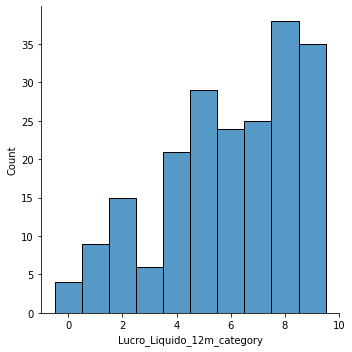

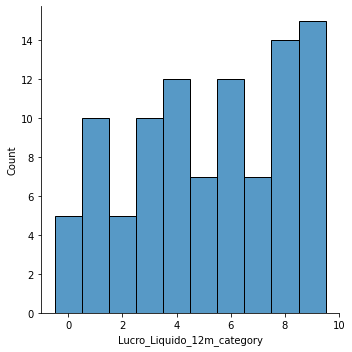

In [30]:
sns.displot(df_tickers[np.isin(df_tickers['Setor'], besst_1)]['Lucro_Liquido_12m_category'])
sns.displot(df_tickers[np.isin(df_tickers['Setor'], besst_2)]['Lucro_Liquido_12m_category'])

In [31]:
df_tickers['besst_1'] = np.isin(df_tickers['Setor'], besst_1)
df_tickers['besst_2'] = np.isin(df_tickers['Setor'], besst_2)

In [32]:
df_tickers['besst_1'].value_counts()

False    618
True     206
Name: besst_1, dtype: int64

In [33]:
df_tickers['besst_2'].value_counts()

False    727
True      97
Name: besst_2, dtype: int64

In [34]:
def from_percent_to_numeric(x):
    return np.float(re.sub('%','',x))/100

In [35]:
df_tickers['Div_Yield'] = df_tickers['Div_Yield'].apply(from_percent_to_numeric)

C:\Users\Pontello\AppData\Local\Temp\ipykernel_3484\1886306178.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(re.sub('%','',x))/100


In [50]:
df_tickers[df_tickers['besst_2']]['Div_Yield'].mean()

0.040319148936170224

In [44]:
df_tickers.dtypes

Papel                             object
Tipo                              object
Empresa                           object
Setor                             object
Subsetor                          object
Cotacao                          float64
Data_ult_cot                      object
Min_52_sem                       float64
Max_52_sem                       float64
Vol_med_2m                         int64
Valor_de_mercado                   int64
Valor_da_firma                    object
Ult_balanco_processado            object
Nro_Acoes                          int64
PL                                 int64
PVP                                int64
PEBIT                             object
PSR                               object
PAtivos                           object
PCap_Giro                         object
PAtiv_Circ_Liq                    object
Div_Yield                        float64
EV_EBITDA                         object
EV_EBIT                           object
Cres_Rec_5a     

Selecting just the tickers with the type we want

In [45]:
df_tickers['Tipo'] = df_tickers['Tipo'].str[:2]
df_tickers = df_tickers.loc[np.isin(df_tickers['Tipo'],['ON','PN'])]

In [46]:
df_tickers['Papel'].str[-1].value_counts()

3    496
4    205
5     39
6     29
7      5
B      5
1      2
2      2
8      1
Name: Papel, dtype: int64

In [47]:
df_tickers['Tipo'].value_counts()

ON    501
PN    283
Name: Tipo, dtype: int64

In [48]:
df_tickers = df_tickers.loc[np.isin(df_tickers['Papel'].str[-1],['3','4','5','6'])]

In [51]:
cat_cols = [col for col in df_tickers.columns if '_category' in col]
list_unequal = []
for col in cat_cols:
    for col_2 in cat_cols:
        list_unequal.append(df_tickers[df_tickers[col].astype(int) - df_tickers[col_2].astype(int) != 0]['Papel'])

In [52]:
list_unequal

[Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object),
 Series([], Name: Papel, dtype: object)]

In [53]:
df_tickers[[col for col in df_tickers.columns if '_category' in col]]

,Valor_de_mercado_category,Lucro_Liquido_12m_category,Receita_Liquida_12m_category,Patrim_Liq_category
ABCB4,7,7,7,7
ABYA3,3,3,3,3
ACES3,7,7,7,7
ACES4,7,7,7,7
ACGU3,1,1,1,1
...,...,...,...,...
CSUD3,3,3,3,3
DMFN3,1,1,1,1
ZAMP3,5,5,5,5
VSTE3,4,4,4,4


In [54]:
# info_papeis = ['Papel','Tipo', 'Empresa', 'Setor', 'Subsetor','Data_ult_cot']
info_tickers = ['Papel','Tipo', 'Empresa', 'Setor', 'Subsetor','Data_ult_cot','Lucro_Liquido_12m_category','besst_1','besst_2']
               
df_tickers_clean = df_tickers[info_tickers]

df_tickers_clean = df_tickers_clean.dropna()
df_tickers_clean = df_tickers_clean.drop_duplicates()

In [55]:
df_tickers_clean['Data_ult_cot'] = pd.to_datetime(df_tickers_clean['Data_ult_cot'])

In [56]:
df_tickers_clean = df_tickers_clean.reset_index(drop=True)

In [57]:
# df_completed = df_tickers_clean.merge(df, how='left', left_on='Papel', right_on='papel').drop_duplicates()
df_completed = df_tickers_clean.merge(df_daily, how='left', left_on='Papel', right_on='papel').drop_duplicates()

In [58]:
df_completed.head()

,Papel,Tipo,Empresa,Setor,Subsetor,Data_ult_cot,Lucro_Liquido_12m_category,besst_1,besst_2,days,papel,cotacao,pl,pvp,psr,dy,pa,pcg,pebit,pacl,evebit,mrgebit,mrgliq,roic,roe,liqc,liq2m,patrliq,divbpatr,c5y,date,year
0,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-13,ABCB4,9.000000,0.000000,1.100000,0.0,0.048900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.160460e+06,1.107010e+09,0.0,0.000000,2008-06-13,2008.0
1,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-14,ABCB4,9.420733,-1.575437,0.992605,0.0,0.082329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108924,0.0,4.138828e+06,1.106996e+09,0.0,0.005520,2008-06-14,2008.0
2,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-15,ABCB4,9.350419,-1.539819,0.992623,0.0,0.082306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108950,0.0,4.116977e+06,1.106984e+09,0.0,0.005535,2008-06-15,2008.0
3,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-16,ABCB4,9.280510,-1.504246,0.992641,0.0,0.082284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108975,0.0,4.094908e+06,1.106973e+09,0.0,0.005549,2008-06-16,2008.0
4,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-17,ABCB4,9.211006,-1.468720,0.992659,0.0,0.082262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109001,0.0,4.072620e+06,1.106964e+09,0.0,0.005563,2008-06-17,2008.0


In [59]:
df_completed.isna().sum().sort_values(ascending=False).iloc[:10]

pa          2
pcg         2
date        2
c5y         2
divbpatr    2
patrliq     2
liq2m       2
liqc        2
roe         2
roic        2
dtype: int64

In [60]:
df_completed.dropna(inplace=True)

In [61]:
df_completed.describe()

,cotacao,pl,pvp,psr,dy,pa,pcg,pebit,pacl,evebit,mrgebit,mrgliq,roic,roe,liqc,liq2m,patrliq,divbpatr,c5y,year
count,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06,2.799390e+06
mean,2.612829e+01,7.306634e+04,9.857786e+03,9.591608e+01,3.292474e-01,8.479381e+02,9.998266e+03,7.258954e+04,9.892902e+03,7.258158e+04,-2.575258e+00,1.213705e+01,2.927560e-01,-3.343850e-01,1.814331e+00,1.031821e+11,5.738434e+09,8.435277e-01,1.590082e-01,2.015881e+03
std,1.442332e+02,6.834816e+06,2.633081e+06,1.120507e+04,1.928501e+01,2.385435e+05,2.636831e+06,6.834396e+06,2.633081e+06,6.849024e+06,9.587224e+01,7.167357e+02,2.026945e+01,9.587095e+01,1.058604e+01,1.765287e+13,2.440063e+10,1.288528e+01,7.885720e+00,4.326385e+00
min,-7.195190e+03,-1.285390e+08,-6.598589e+05,-4.739047e+05,-1.168968e+03,-4.687217e+05,-8.141561e+06,-1.285388e+08,-5.727057e+05,-1.288137e+08,-5.710836e+03,-9.152641e+03,-8.944437e+02,-5.472209e+03,-1.280964e+02,-9.573140e+13,-1.309642e+11,-9.712376e+02,-7.406254e+02,2.008000e+03
25%,4.481085e+00,-4.410321e-01,5.200000e-01,1.913189e-01,0.000000e+00,1.610528e-01,-1.767465e-02,0.000000e+00,-1.895317e+00,0.000000e+00,0.000000e+00,-2.754445e-02,0.000000e+00,0.000000e+00,5.561361e-01,7.713689e-04,9.252960e+07,0.000000e+00,-6.551759e-03,2.012000e+03
50%,1.232982e+01,7.214447e+00,1.180000e+00,7.440862e-01,1.106074e-02,4.700000e-01,1.265062e+00,4.435744e+00,-2.318869e-01,6.877986e+00,6.541179e-02,2.312458e-02,4.852267e-02,8.876579e-02,1.270278e+00,1.691012e+04,7.954715e+08,3.222355e-01,6.872400e-02,2.016000e+03
75%,2.787480e+01,1.620356e+01,2.224434e+00,1.726027e+00,4.386412e-02,9.080780e-01,5.279674e+00,1.007786e+01,2.962774e-01,1.416604e+01,1.640000e-01,1.041278e-01,1.154904e-01,1.756199e-01,2.050000e+00,2.316314e+06,2.588856e+09,1.022069e+00,1.334000e-01,2.020000e+03
max,9.740744e+03,7.296197e+08,1.004454e+09,9.099389e+05,1.547888e+03,9.098313e+07,1.004454e+09,7.296189e+08,1.004454e+09,7.311792e+08,3.142613e+03,5.206307e+04,1.750496e+03,5.928227e+03,9.098513e+02,3.656170e+15,4.105450e+11,1.321868e+03,1.872520e+03,2.023000e+03


In [62]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path_local = '../data/02_refined/'
filename = 'df_completed_daily.parquet'
blob_name = '03_refined/'

# save the DataFrame as a parquet file
df_completed.to_parquet(path_local + filename)

# upload the parquet file to Google Cloud Storage
blob = bucket.blob(blob_name + filename)
blob._chunk_size = 8388608
blob.upload_from_filename(path_local + filename, num_retries=10, )

## 3 - Data Preparation

In [63]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

In [64]:
path = "gs://storage-barsianize/03_refined/df_completed_daily.parquet"
df_completed =  pd.read_parquet(path)

In [65]:
df_completed.dtypes

Papel                                 object
Tipo                                  object
Empresa                               object
Setor                                 object
Subsetor                              object
Data_ult_cot                  datetime64[ns]
Lucro_Liquido_12m_category             int64
besst_1                                 bool
besst_2                                 bool
days                          datetime64[ns]
papel                                 object
cotacao                              float64
pl                                   float64
pvp                                  float64
psr                                  float64
dy                                   float64
pa                                   float64
pcg                                  float64
pebit                                float64
pacl                                 float64
evebit                               float64
mrgebit                              float64
mrgliq    

In [ ]:
"Papel"	"Tipo"	"Empresa"	Setor	Subsetor	Data_ult_cot	Lucro_Liquido_12m_category	besst_1	besst_2 year

In [72]:
df_completed

,Papel,Tipo,Empresa,Setor,Subsetor,Data_ult_cot,Lucro_Liquido_12m_category,besst_1,besst_2,days,papel,cotacao,pl,pvp,psr,dy,pa,pcg,pebit,pacl,evebit,mrgebit,mrgliq,roic,roe,liqc,liq2m,patrliq,divbpatr,c5y,date,year
0,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-13,ABCB4,9.000000,0.000000,1.100000,0.000000,0.048900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.160460e+06,1.107010e+09,0.000000,0.000000,2008-06-13,2008.0
1,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-14,ABCB4,9.420733,-1.575437,0.992605,0.000000,0.082329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108924,0.000000,4.138828e+06,1.106996e+09,0.000000,0.005520,2008-06-14,2008.0
2,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-15,ABCB4,9.350419,-1.539819,0.992623,0.000000,0.082306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108950,0.000000,4.116977e+06,1.106984e+09,0.000000,0.005535,2008-06-15,2008.0
3,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-16,ABCB4,9.280510,-1.504246,0.992641,0.000000,0.082284,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.108975,0.000000,4.094908e+06,1.106973e+09,0.000000,0.005549,2008-06-16,2008.0
4,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,2008-06-17,ABCB4,9.211006,-1.468720,0.992659,0.000000,0.082262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109001,0.000000,4.072620e+06,1.106964e+09,0.000000,0.005563,2008-06-17,2008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805217,ZAMP3,ON,ZAMP S.A. ON,Hoteis e Restaurantes,Restaurante e Similares,2023-04-24,5,False,False,2023-04-15,ZAMP3,4.142051,-20.488629,0.769348,0.312845,0.000000,0.276393,17.651095,11.758436,-0.697374,16.855970,0.026533,-0.015265,0.029841,-0.037519,1.069392,7.160043e+06,1.485361e+09,0.679635,0.087350,2023-04-15,2023.0
2805218,ZAMP3,ON,ZAMP S.A. ON,Hoteis e Restaurantes,Restaurante e Similares,2023-04-24,5,False,False,2023-04-16,ZAMP3,4.129082,-20.415603,0.767015,0.311884,0.000000,0.275545,17.578743,11.727934,-0.695520,16.828160,0.026526,-0.015272,0.029832,-0.037537,1.069523,7.221896e+06,1.485324e+09,0.679714,0.087361,2023-04-16,2023.0
2805219,ZAMP3,ON,ZAMP S.A. ON,Hoteis e Restaurantes,Restaurante e Similares,2023-04-24,5,False,False,2023-04-17,ZAMP3,4.116084,-20.341490,0.764679,0.310923,0.000000,0.274697,17.504443,11.698028,-0.693673,16.801228,0.026518,-0.015281,0.029823,-0.037556,1.069668,7.285048e+06,1.485284e+09,0.679801,0.087373,2023-04-17,2023.0
2805220,ZAMP3,ON,ZAMP S.A. ON,Hoteis e Restaurantes,Restaurante e Similares,2023-04-24,5,False,False,2023-04-18,ZAMP3,4.103056,-20.266289,0.762341,0.309961,0.000000,0.273849,17.428196,11.668716,-0.691833,16.775175,0.026509,-0.015290,0.029812,-0.037577,1.069827,7.349500e+06,1.485239e+09,0.679896,0.087386,2023-04-18,2023.0


In [102]:
def aggregator_monthly(data, tickers, ticker_col, date_col,agg_dict):

    df_agg_monthly_full = []
    for ticker in tickers:
        df_agg_monthly = data.loc[data[ticker_col]==ticker].resample('M', on=date_col).agg(agg_dict)
        df_agg_monthly_full.append(df_agg_monthly)

    df_agg_monthly_full = pd.concat(df_agg_monthly_full).reset_index(drop=True)
    df_agg_monthly_full.columns = [x[0]+'_'+x[1] if 'first'!=x[1] else x[0] for x in df_agg_monthly_full.columns]

    return df_agg_monthly_full

In [173]:
ticker_col = 'Papel'
date_col = 'date'
tickers = list(df_completed[ticker_col].unique())
agg_dict = {
        'Papel':'first',
        'Tipo':'first',
        'Empresa':'first',
        'Setor':'first',
        'Subsetor':'first',
        'Data_ult_cot':'first',
        'Lucro_Liquido_12m_category':'first',
        'besst_1':'first',
        'besst_2':'first',
        'cotacao':['max','min','mean'],
        'pl':['max','min','mean'],
        'pvp':['max','min','mean'],
        'psr':['max','min','mean'],
        'dy':['max','min','mean'],
        'pa':['max','min','mean'],
        'pcg':['max','min','mean'],
        'pebit':['max','min','mean'],
        'pacl':['max','min','mean'],
        'evebit':['max','min','mean'],
        'mrgebit':['max','min','mean'],
        'mrgliq':['max','min','mean'],
        'roic':['max','min','mean'],
        'roe':['max','min','mean'],
        'liqc':['max','min','mean'],
        'liq2m':['max','min','mean'],
        'patrliq':['max','min','mean'],
        'divbpatr':['max','min','mean'],
        'c5y':['max','min','mean'],
        'date':'last',
        'year':'first'
        }

df_agg_monthly = aggregator_monthly(df_completed, tickers, ticker_col, date_col, agg_dict)

In [174]:
df_agg_monthly.head()

,Papel,Tipo,Empresa,Setor,Subsetor,Data_ult_cot,Lucro_Liquido_12m_category,besst_1,besst_2,cotacao_max,cotacao_min,cotacao_mean,pl_max,pl_min,pl_mean,pvp_max,pvp_min,pvp_mean,psr_max,psr_min,psr_mean,dy_max,dy_min,dy_mean,pa_max,pa_min,pa_mean,pcg_max,pcg_min,pcg_mean,pebit_max,pebit_min,pebit_mean,pacl_max,pacl_min,pacl_mean,evebit_max,evebit_min,evebit_mean,mrgebit_max,mrgebit_min,mrgebit_mean,mrgliq_max,mrgliq_min,mrgliq_mean,roic_max,roic_min,roic_mean,roe_max,roe_min,roe_mean,liqc_max,liqc_min,liqc_mean,liq2m_max,liq2m_min,liq2m_mean,patrliq_max,patrliq_min,patrliq_mean,divbpatr_max,divbpatr_min,divbpatr_mean,c5y_max,c5y_min,c5y_mean,date_last,year
0,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,9.420733,8.344365,8.881414,0.000000,-1.575437,-1.220533,1.100000,0.992605,0.998706,0.0,0.0,0.0,0.082329,0.048900,0.080305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109332,0.000000,0.103066,0.0,0.0,0.0,4.160460e+06,3.762985e+06,3.966677e+06,1.107010e+09,1.106940e+09,1.106962e+09,0.0,0.0,0.0,0.005751,0.000000,0.005322,2008-06-30,2008.0
1,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,8.930000,6.554353,7.411039,0.048980,-0.976174,-0.429903,1.090000,0.992908,0.996303,0.0,0.0,0.0,0.081954,0.049300,0.080574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110113,0.000000,0.106207,0.0,0.0,0.0,3.737637e+06,2.875544e+06,3.322438e+06,1.108088e+09,1.106996e+09,1.107430e+09,0.0,0.0,0.0,0.006203,0.000000,0.005797,2008-07-31,2008.0
2,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,6.503100,5.154084,5.799189,1.064896,0.082440,0.576997,0.993964,0.993451,0.993708,0.0,0.0,0.0,0.081278,0.080631,0.080954,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110884,0.110138,0.110512,0.0,0.0,0.0,2.843419e+06,1.788165e+06,2.327293e+06,1.110794e+09,1.108148e+09,1.109310e+09,0.0,0.0,0.0,0.006664,0.006218,0.006440,2008-08-31,2008.0
3,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,5.115403,4.170072,4.615295,2.006032,1.096933,1.554589,0.994465,0.993981,0.994223,0.0,0.0,0.0,0.080610,0.079991,0.080300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111620,0.110909,0.111265,0.0,0.0,0.0,1.753722e+06,1.012372e+06,1.342992e+06,1.120192e+09,1.110953e+09,1.114850e+09,0.0,0.0,0.0,0.007117,0.006679,0.006897,2008-09-30,2008.0
4,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,4.143558,3.200000,3.794062,3.220000,2.036691,2.508900,0.994969,0.380000,0.974894,0.0,0.0,0.0,0.215600,0.079338,0.084041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119000,0.111645,0.112231,0.0,0.0,0.0,9.956878e+05,7.688541e+05,8.401325e+05,1.139988e+09,1.120670e+09,1.129556e+09,0.0,0.0,0.0,0.007593,0.000000,0.007123,2008-10-31,2008.0


In [118]:
import requests
import pandas as pd

def correct_data_column(x):
    date = x.split('/')
    new_date = '-'.join(date[::-1])
    return new_date

def get_bcb_data(codes, start_date, end_date, output_format='json'):
    """
    Get macroeconomic data from the Brazilian Central Bank's API.

    Args:
        codes (list): List of series codes to retrieve. See the API documentation for available codes.
        start_date (str): Start date in format 'dd/mm/yyyy'.
        end_date (str): End date in format 'dd/mm/yyyy'.
        output_format (str, optional): Output format, either 'json' or 'csv'. Defaults to 'json'.

    Returns:
        pandas.DataFrame: DataFrame with the requested series data.

    Raises:
        ValueError: If the output format is invalid.
        requests.exceptions.RequestException: If the API request fails.

    Example:
        Get the values of the crude oil production, commodities, dollar, euro, IPCA, IGPM, and Selic series from January 1st, 2021 to December 31st, 2021 in JSON format:

        >>> codes = [13522, 13521, 4390, 189, 11, 1178]
        >>> start_date = '01/01/2021'
        >>> end_date = '31/12/2021'
        >>> output_format = 'json'
        >>> df = get_bcb_data(codes, start_date, end_date, output_format)

    """
    # Define the base URL of the API
    url_base = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados"

    # Define the output format parameter
    if output_format not in ['json', 'csv']:
        raise ValueError("Invalid output format. Must be 'json' or 'csv'.")
    formato = output_format

    # Create a dictionary to store the series DataFrames
    dataframes = {}

    # Get the data for each series and store it in a DataFrame
    for code_name, code in codes.items():
        # Build the complete URL with the defined parameters
        url = url_base.format(code) + f"?formato={formato}&dataInicial={start_date}&dataFinal={end_date}"
        # Make the API request
        response = requests.get(url)
        # Check if the request was successful
        if response.status_code == 200:
            # Convert the response to a pandas DataFrame and set the column name to the series code
            try:
                df = pd.read_json(response.text)
            except:
                try:
                    df = pd.read_xml(response.text)
                except:
                    continue
            col_name = code_name
            df = df.rename(columns={"valor": col_name})
            # Set the DataFrame index to the date
            df = df.set_index("data")
            # Store the DataFrame in the dictionary
            dataframes[col_name] = df[col_name]
        else:
            raise requests.exceptions.RequestException(f"Error getting data. HTTP status code: {response.status_code}")

    # Combine the DataFrames for each series into a single DataFrame
    final_df = pd.concat(dataframes.values(), axis=1).reset_index()

    return final_df

In [160]:
# https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

codes = {
    'preco_do_petroleo': 4390,
    'preco_do_minerio_de_ferro': 25521,
    'indice_da_industria': 24369,
    'indice_do_agro': 24368,
    'dolar_comercial': 1,
    'euro': 21619,
    'ibovespa': 23686,
    'pib': 21920,
    'pib_dolarizado': 22786,
    'igpm': 189,
    'ipca': 433,
    'selic': 11
}
start_date = "01/01/2008"
end_date = "28/02/2023"
output_format='json'

df_bcb = get_bcb_data(codes, start_date, end_date, output_format=output_format)

In [161]:
df_bcb['data'] = pd.to_datetime(df_bcb['data'].apply(correct_data_column))

In [165]:
df_bcb = df_bcb.fillna(method='ffill').fillna(method='bfill')

agg_dict = {
        'data':'first',
        'preco_do_petroleo':'mean',
        'indice_da_industria':'mean',
        'dolar_comercial':'mean',
        'euro':'mean',
        'ibovespa':'mean',
        'pib_dolarizado':'mean',
        'igpm':'mean',
        'ipca':'mean',
        'selic':'mean',
        }
df_bcb_agg = df_bcb.resample('M', on='data').agg(agg_dict)
df_bcb_agg = df_bcb_agg.reset_index(drop=True)

In [166]:
df_bcb_agg

,data,preco_do_petroleo,indice_da_industria,dolar_comercial,euro,ibovespa,pib_dolarizado,igpm,ipca,selic
0,2007-12-31,0.920000,8.600000,1.771300,2.608590,240413.500000,1544.900000,-0.060000,0.840000,0.042065
1,2008-01-01,0.920435,8.573913,1.772991,2.610880,241579.308696,1529.178261,-0.010000,0.826957,0.042059
2,2008-02-01,0.913684,8.568421,1.727742,2.549660,241824.742105,1504.184211,-0.028947,0.821579,0.042063
3,2008-03-01,0.916190,8.571429,1.709367,2.648507,241690.338095,1524.085714,-0.021905,0.822857,0.042062
4,2008-04-01,0.919048,8.571429,1.688929,2.659859,241690.338095,1519.214286,-0.024286,0.826190,0.042742
...,...,...,...,...,...,...,...,...,...,...
178,2022-10-01,0.924762,8.585714,5.247938,5.174133,240413.500000,1544.228571,-0.103333,0.828095,0.050788
179,2022-11-01,0.925000,8.575000,5.274650,5.391545,240413.500000,1547.165000,-0.085000,0.818500,0.050788
180,2022-12-01,0.929091,8.568182,5.242432,5.551541,240413.500000,1553.486364,-0.036818,0.830000,0.050788
181,2023-01-01,0.928696,8.591304,5.200426,5.594422,240413.500000,1554.704348,-0.048261,0.826522,0.050788


In [175]:
df_bcb_agg['month'] = df_bcb_agg['data'].dt.month
df_bcb_agg['year'] = df_bcb_agg['data'].dt.year

df_agg_monthly['month'] = df_agg_monthly['date_last'].dt.month

In [177]:
df_monthly_full = df_agg_monthly.merge(df_bcb_agg, how='left', left_on=['month','year'], right_on=['month','year'])

In [178]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path_local = '../data/02_refined/'
filename = 'df_monthly_full.parquet'
blob_name = '03_refined/'

# save the DataFrame as a parquet file
df_monthly_full.to_parquet(path_local + filename)

# upload the parquet file to Google Cloud Storage
blob = bucket.blob(blob_name + filename)
blob._chunk_size = 8388608
blob.upload_from_filename(path_local + filename, num_retries=10, )

### Create base dataset

In [ ]:
df_monthly_full.

In [167]:
df_agg_monthly

,Papel,Tipo,Empresa,Setor,Subsetor,Data_ult_cot,Lucro_Liquido_12m_category,besst_1,besst_2,cotacao_max,cotacao_min,cotacao_mean,cotacao_median,cotacao_last,pl_max,pl_min,pl_mean,pl_median,pl_last,pvp_max,pvp_min,pvp_mean,pvp_median,pvp_last,psr_max,psr_min,psr_mean,psr_median,psr_last,dy_max,dy_min,dy_mean,dy_median,dy_last,pa_max,pa_min,pa_mean,pa_median,pa_last,pcg_max,pcg_min,pcg_mean,pcg_median,pcg_last,pebit_max,pebit_min,pebit_mean,pebit_median,pebit_last,pacl_max,pacl_min,pacl_mean,pacl_median,pacl_last,evebit_max,evebit_min,evebit_mean,evebit_median,evebit_last,mrgebit_max,mrgebit_min,mrgebit_mean,mrgebit_median,mrgebit_last,mrgliq_max,mrgliq_min,mrgliq_mean,mrgliq_median,mrgliq_last,roic_max,roic_min,roic_mean,roic_median,roic_last,roe_max,roe_min,roe_mean,roe_median,roe_last,liqc_max,liqc_min,liqc_mean,liqc_median,liqc_last,liq2m_max,liq2m_min,liq2m_mean,liq2m_median,liq2m_last,patrliq_max,patrliq_min,patrliq_mean,patrliq_median,patrliq_last,divbpatr_max,divbpatr_min,divbpatr_mean,divbpatr_median,divbpatr_last,c5y_max,c5y_min,c5y_mean,c5y_median,c5y_last,date_last,year
0,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,9.420733,8.344365,8.881414,8.903309,8.344365,0.000000,-1.575437,-1.220533,-1.274153,-1.011058,1.100000,0.992605,0.998706,0.992757,0.992890,0.000000,0.000000,0.000000,0.000000,0.000000,0.082329,0.048900,0.080305,0.082141,0.081976,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109332,0.000000,0.103066,0.109116,0.109332,0.000000,0.000000,0.000000,0.000000,0.000000,4.160460e+06,3.762985e+06,3.966677e+06,3.969592e+06,3.762985e+06,1.107010e+09,1.106940e+09,1.106962e+09,1.106956e+09,1.106984e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.005751,0.000000,0.005322,0.005628,0.005751,2008-06-30,2008.0
1,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,8.930000,6.554353,7.411039,7.371821,6.554353,0.048980,-0.976174,-0.429903,-0.424283,0.048980,1.090000,0.992908,0.996303,0.993190,0.993433,0.000000,0.000000,0.000000,0.000000,0.000000,0.081954,0.049300,0.080574,0.081604,0.081300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110113,0.000000,0.106207,0.109736,0.110113,0.000000,0.000000,0.000000,0.000000,0.000000,3.737637e+06,2.875544e+06,3.322438e+06,3.331182e+06,2.875544e+06,1.108088e+09,1.106996e+09,1.107430e+09,1.107368e+09,1.108088e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.006203,0.000000,0.005797,0.005983,0.006203,2008-07-31,2008.0
2,ABCB4,PN,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-04-24,7,True,False,6.503100,5.154084,5.799189,5.782966,5.154084,1.064896,0.082440,0.576997,0.578833,1.064896,0.993964,0.993451,0.993708,0.993709,0.993964,0.000000,0.000000,0.000000,0.000000,0.000000,0.081278,0.080631,0.080954,0.080954,0.080631,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110884,0.110138,0.110512,0.110512,0.110884,0.000000,0.000000,0.000000,0.000000,0.000000,2.843419e+06,1.788165e+06,2.327293e+06,2.335318e+06,1.788165e+06,1.110794e+09,1.108148e+09,1.109310e+09,1.109240e+09,1.110794e+09,0.000000

In [31]:
def interpolate_data(serie, time_begin, time_ends):
    # define the time range for the spline
    time_range = pd.date_range(time_begin, time_ends, freq='D')

    # create an interpolation function using a cubic spline
    f = interp1d(serie.index.astype(int), serie.values, kind='cubic')

    # evaluate the interpolation function at the new time points
    new_data = pd.Series(f(time_range.astype(int)), index=time_range)

    return new_data

In [28]:
df_completed.head()

,Papel,Tipo,Empresa,Setor,Subsetor,Data_ult_cot,papel,cotacao,pl,pvp,psr,dy,pa,pcg,pebit,pacl,evebit,mrgebit,mrgliq,roic,roe,liqc,liq2m,patrliq,divbpatr,c5y,year,date
0,ABCB3,ON N2,ABC Brasil ON N2,Intermediários Financeiros,Bancos,1899-12-30,ABCB3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,1.107010e+09,0.0,0.0000,2008,2008-06-13
736,ABCB3,ON N2,ABC Brasil ON N2,Intermediários Financeiros,Bancos,1899-12-30,ABCB3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1553,0.0,0.0,1.158760e+09,0.0,0.0000,2009,2009-01-23
1478,ABCB3,ON N2,ABC Brasil ON N2,Intermediários Financeiros,Bancos,1899-12-30,ABCB3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1016,0.0,0.0,1.182180e+09,0.0,-0.1233,2010,2010-01-15
2237,ABCB3,ON N2,ABC Brasil ON N2,Intermediários Financeiros,Bancos,1899-12-30,ABCB3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1521,0.0,0.0,1.312080e+09,0.0,0.1043,2011,2011-01-13
3020,ABCB3,ON N2,ABC Brasil ON N2,Intermediários Financeiros,Bancos,1899-12-30,ABCB3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1571,0.0,0.0,1.460150e+09,0.0,0.1272,2012,2012-01-06


In [29]:
df_bb = df_completed.loc[df_completed['Papel']=='BBAS3']

In [34]:
df_bb['date'].max()

Timestamp('2023-03-24 00:00:00')

In [41]:
df_bb = pd.DataFrame(pd.date_range(df_bb['date'].min(), df_bb['date'].max(), freq='D'), columns=['days']).merge(df_bb, how='left', left_on='days', right_on='date')

In [42]:
df_bb.head()

,days,Papel,Tipo,Empresa,Setor,Subsetor,Data_ult_cot,papel,cotacao,pl,pvp,psr,dy,pa,pcg,pebit,pacl,evebit,mrgebit,mrgliq,roic,roe,liqc,liq2m,patrliq,divbpatr,c5y,year,date
0,2008-06-13,BBAS3,ON,BANCO DO BRASIL S.A. ON,Intermediários Financeiros,Bancos,2023-01-04,BBAS3,29.61,12.55,2.96,0.0,0.0273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.236,0.0,123934000.0,2.540680e+10,0.0,0.0972,2008.0,2008-06-13
1,2008-06-14,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,2008-06-15,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,2008-06-16,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,2008-06-17,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [35]:
df_bb[['date']].interpolate(method='time',)

ValueError: Invalid fill method. Expecting pad (ffill) or backfill (bfill). Got time

In [32]:
interpolate_data(df_bb['cotacao'],df_bb['date'].min(), df_bb['date'].max())

ValueError: A value in x_new is above the interpolation range.

In [25]:
df_completed.columns

Index(['Papel', 'Tipo', 'Empresa', 'Setor', 'Subsetor', 'Data_ult_cot',
       'papel', 'cotacao', 'pl', 'pvp', 'psr', 'dy', 'pa', 'pcg', 'pebit',
       'pacl', 'evebit', 'mrgebit', 'mrgliq', 'roic', 'roe', 'liqc', 'liq2m',
       'patrliq', 'divbpatr', 'c5y', 'year', 'date'],
      dtype='object')

In [26]:
df_completed['Data_ult_cot_year'] = df_completed['Data_ult_cot'].dt.year

In [27]:
df_actual = df_completed[df_completed['Data_ult_cot_year'] == pd.to_datetime(date.today()).year]

In [28]:
tickers = df_actual['Papel'].unique()

In [29]:
tickers

array(['ABCB4', 'AGRO3', 'ALPA3', 'ALPA4', 'AZEV3', 'AZEV4', 'BAHI3',
       'BALM3', 'BALM4', 'BAZA3', 'BBAS3', 'BBDC3', 'BBDC4', 'BDLL4',
       'BEEF3', 'BEES3', 'BGIP4', 'BIOM3', 'BMEB3', 'BMEB4', 'BMIN3',
       'BMIN4', 'BMKS3', 'BOBR4', 'BRAP3', 'BRAP4', 'BRGE11', 'BRGE3',
       'BRIV3', 'BRIV4', 'BRKM3', 'BRKM5', 'BRML3', 'BRSR3', 'BRSR5',
       'BRSR6', 'CALI3', 'CAMB3', 'CBEE3', 'CCRO3', 'CEBR3', 'CEBR5',
       'CEBR6', 'CEDO4', 'CEEB3', 'CGAS3', 'CGAS5', 'CGRA3', 'CGRA4',
       'CLSC3', 'CMIG3', 'CMIG4', 'COCE5', 'CPFE3', 'CPLE3', 'CPLE6',
       'CRIV3', 'CRIV4', 'CSAB3', 'CSAB4', 'CSAN3', 'CSMG3', 'CSNA3',
       'CSRN3', 'CSRN5', 'CSRN6', 'CTKA4', 'CTNM4', 'CTSA3', 'CTSA4',
       'CYRE3', 'DASA3', 'DOHL4', 'EALT3', 'EALT4', 'EKTR3', 'EKTR4',
       'ELET3', 'ELET6', 'EMAE4', 'EMBR3', 'ENBR3', 'ENGI3', 'ENGI4',
       'EQTL3', 'ESTR4', 'ETER3', 'EUCA3', 'EUCA4', 'EVEN3', 'EZTC3',
       'FESA3', 'FESA4', 'FHER3', 'GEPA3', 'GEPA4', 'GFSA3', 'GGBR3',
       'GGBR4', 'GO

In [30]:
stock_info = ['Papel','Tipo','Empresa','Setor','Subsetor']

indicators = ['cotacao', 'pl', 'pvp', 'psr', 'dy', 'pa', 'pcg', 'pebit',
              'pacl', 'evebit', 'mrgebit', 'mrgliq', 'roic', 'roe', 'liqc', 'liq2m',
              'patrliq', 'divbpatr', 'c5y','date','year']

In [31]:
df_indicators = df_actual[np.isin(df_actual['Papel'],tickers)][stock_info + indicators]

In [32]:
data = df_actual[df_actual['Papel']==tickers[2]].sort_values('year', ascending=False)

max = data['year'].max()
min = data['year'].min()
windows = get_windows(max, min, window=5, step=1)

### Get relative information for each sector

In [33]:
cols_to_rel = ['mrgliq','liq2m','patrliq','mrgebit','c5y']

def relativize(data, cols, sector_col, window):
    """
    Relativize the values in a DataFrame by dividing them by the corresponding values in a reference DataFrame.

    Parameters
    ----------
    data : pandas.DataFrame
        The DataFrame to relativize.
    cols : list of str
        The column names to relativize.
    sector_col : str
        The name of the column containing the sector information.

    Returns
    -------
    pandas.DataFrame
        A copy of the input DataFrame `data` with the specified columns relativized.
    """
    data_out = data.copy()
    sectors = data_out[sector_col].unique()
    max_window = np.max(window)

    ref_data = data_out.groupby(sector_col)[cols].mean()
    
    
    data_out = data_out[data_out['year']==max_window]
    for sector in sectors:
        sector_data = data_out.loc[data_out[sector_col] == sector]
        for col in cols:
            sector_data[col] /= ref_data.at[sector, col]
        data_out.loc[data_out[sector_col] == sector] = sector_data
    # data_out = data_out[[sector_col] + cols + ['year','Papel']]

    ref_data.columns = [col+'_field' for col in ref_data.columns]
    ref_data['year'] = max_window
    
    return ref_data, data_out

In [34]:
max = 2023
min = 2008

windows = get_windows(max, min, window=5, step=1)

In [35]:
databases = []
for window in windows:
    
    ref_data, data_out = relativize(df_actual[np.isin(df_actual['year'],window)], cols_to_rel, 'Setor',window)
    database = data_out.merge(ref_data, how='left', left_on='Setor',right_index=True)
    databases.append(database)

database_full = pd.concat(databases)

database_full['year'] = database_full['year_x'].astype(int)
database_full.drop(['year_x','year_y'],axis=1, inplace=True)

C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\1993705781.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_data[col] /= ref_data.at[sector, col]
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\1993705781.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_data[col] /= ref_data.at[sector, col]
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\1993705781.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [36]:
import requests
import pandas as pd

def get_bcb_data(codes, start_date, end_date, output_format='json'):
    """
    Get macroeconomic data from the Brazilian Central Bank's API.

    Args:
        codes (list): List of series codes to retrieve. See the API documentation for available codes.
        start_date (str): Start date in format 'dd/mm/yyyy'.
        end_date (str): End date in format 'dd/mm/yyyy'.
        output_format (str, optional): Output format, either 'json' or 'csv'. Defaults to 'json'.

    Returns:
        pandas.DataFrame: DataFrame with the requested series data.

    Raises:
        ValueError: If the output format is invalid.
        requests.exceptions.RequestException: If the API request fails.

    Example:
        Get the values of the crude oil production, commodities, dollar, euro, IPCA, IGPM, and Selic series from January 1st, 2021 to December 31st, 2021 in JSON format:

        >>> codes = [13522, 13521, 4390, 189, 11, 1178]
        >>> start_date = '01/01/2021'
        >>> end_date = '31/12/2021'
        >>> output_format = 'json'
        >>> df = get_bcb_data(codes, start_date, end_date, output_format)

    """
    # Define the base URL of the API
    url_base = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados"

    # Define the output format parameter
    if output_format not in ['json', 'csv']:
        raise ValueError("Invalid output format. Must be 'json' or 'csv'.")
    formato = output_format

    # Create a dictionary to store the series DataFrames
    dataframes = {}

    # Get the data for each series and store it in a DataFrame
    for code_name, code in codes.items():
        # Build the complete URL with the defined parameters
        url = url_base.format(code) + f"?formato={formato}&dataInicial={start_date}&dataFinal={end_date}"
        # Make the API request
        response = requests.get(url)
        # Check if the request was successful
        if response.status_code == 200:
            # Convert the response to a pandas DataFrame and set the column name to the series code
            try:
                df = pd.read_json(response.text)
            except:
                try:
                    df = pd.read_xml(response.text)
                except:
                    continue
            col_name = code_name
            df = df.rename(columns={"valor": col_name})
            # Set the DataFrame index to the date
            df = df.set_index("data")
            # Store the DataFrame in the dictionary
            dataframes[col_name] = df[col_name]
        else:
            raise requests.exceptions.RequestException(f"Error getting data. HTTP status code: {response.status_code}")

    # Combine the DataFrames for each series into a single DataFrame
    final_df = pd.concat(dataframes.values(), axis=1)

    return final_df

In [37]:
# https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries

codes = {
    'preco_do_petroleo': 4390,
    'preco_do_minerio_de_ferro': 25521,
    'indice_da_industria': 24369,
    'indice_do_agro': 24368,
    'dolar_comercial': 1,
    'euro': 21619,
    'ibovespa': 23686,
    'pib': 21920,
    'pib_dolarizado': 22786,
    'igpm': 189,
    'ipca': 433,
    'selic': 11
}
start_date = "01/01/2008"
end_date = "28/02/2023"
output_format='json'

final_df = get_bcb_data(codes, start_date, end_date, output_format=output_format)

In [38]:
final_df

,preco_do_petroleo,indice_da_industria,dolar_comercial,euro,ibovespa,pib_dolarizado,igpm,ipca,selic
data,,,,,,,,,
01/01/2008,0.93,NaN,NaN,NaN,267227.1,1183.3,1.09,0.54,NaN
01/02/2008,0.80,NaN,1.7451,2.58659,NaN,771.3,0.53,0.49,0.042065
01/03/2008,0.84,NaN,NaN,NaN,NaN,1107.8,0.74,0.48,NaN
01/04/2008,0.90,NaN,1.7534,2.73574,NaN,1005.5,0.69,0.55,0.042065
01/05/2008,0.88,NaN,NaN,NaN,NaN,838.4,1.61,0.79,NaN
...,...,...,...,...,...,...,...,...,...
22/02/2023,NaN,NaN,5.1730,5.49790,NaN,NaN,NaN,NaN,0.050788
23/02/2023,NaN,NaN,5.1330,5.44050,NaN,NaN,NaN,NaN,0.050788
24/02/2023,NaN,NaN,5.1791,5.46080,NaN,NaN,NaN,NaN,0.050788


In [39]:
final_df = final_df.sort_values(by='data').reset_index()
final_df['data'] = pd.to_datetime(final_df['data'])
final_df['year'] = final_df['data'].dt.year
final_df['month'] = final_df['data'].dt.month
final_df = final_df.groupby(pd.Grouper(key='data', freq='Y',origin=0, label='left')).first()\
                    .fillna(0).reset_index()

bc_data_columns = final_df.columns
database_full['date'] = pd.to_datetime(database_full['date'])
database_full['year'] = database_full['date'].dt.year
database_full = database_full.copy()
database_full = database_full.merge(final_df, how='left', on='year')

C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\436442326.py:2: UserWarning: Parsing '13/01/2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  final_df['data'] = pd.to_datetime(final_df['data'])
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\436442326.py:2: UserWarning: Parsing '13/01/2010' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  final_df['data'] = pd.to_datetime(final_df['data'])
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\436442326.py:2: UserWarning: Parsing '13/01/2011' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  final_df['data'] = pd.to_datetime(final_df['data'])
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\436442326.py:2: UserWarning: Parsing '13/01/2012' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  final_df['data'] = pd.to_datetim

In [40]:
database_full.head()

,Papel,Tipo,Empresa,Setor,Subsetor,Data_ult_cot,papel,cotacao,pl,pvp,psr,dy,pa,pcg,pebit,pacl,evebit,mrgebit,mrgliq,roic,roe,liqc,liq2m,patrliq,divbpatr,c5y,date,Data_ult_cot_year,mrgliq_field,liq2m_field,patrliq_field,mrgebit_field,c5y_field,year,data,preco_do_petroleo,indice_da_industria,dolar_comercial,euro,ibovespa,pib_dolarizado,igpm,ipca,selic,month
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,2023-01-04,ABCB4,14.19,8.75,1.22,0.000,0.0334,0.000,0.00,0.00,0.00,0.00,-0.000000,0.000000,0.0000,0.1389,0.00,0.198734,0.104159,0.00,0.623592,2013-01-05,2023,0.202566,2.188247e+07,1.573185e+10,-0.245499,0.136948,2013,2012-12-31,0.6,7.3,1.9843,2.6981,202662.4,1656.7,0.34,0.86,0.02726,1
1,AGRO3,ON NM,BRASILAGRO ON NM,Agropecuária,Agricultura,2023-01-04,AGRO3,10.09,-22.64,1.06,3.842,0.0000,0.808,5.25,-28.57,16.14,-30.41,0.347950,-0.609352,-0.0327,-0.0468,2.16,0.171306,0.687695,0.16,1.370918,2013-01-05,2023,0.288175,2.133847e+06,8.092218e+08,-0.386550,0.543067,2013,2012-12-31,0.6,7.3,1.9843,2.6981,202662.4,1656.7,0.34,0.86,0.02726,1
2,ALPA3,ON N1,ALPARGATAS ON N1,"Tecidos, Vestuário e Calçados",Calçados,2023-01-04,ALPA3,14.95,21.33,3.60,2.033,0.0142,2.107,5.44,18.14,7.73,17.01,1.832448,6.775139,0.1895,0.1686,2.30,1.871477,3.179211,0.19,2.004121,2013-01-05,2023,0.014096,4.858312e+05,5.084878e+08,0.061175,0.082829,2013,2012-12-31,0.6,7.3,1.9843,2.6981,202662.4,1656.7,0.34,0.86,0.02726,1
3,ALPA4,PN N1,ALPARGATAS PN N1,"Tecidos, Vestuário e Calçados",Calçados,2023-01-04,ALPA4,15.15,21.62,3.64,2.060,0.0154,2.136,5.51,18.38,7.84,17.25,1.832448,6.775139,0.1895,0.1686,2.30,11.222601,3.179211,0.19,2.004121,2013-01-05,2023,0.014096,4.858312e+05,5.084878e+08,0.061175,0.082829,2013,2012-12-31,0.6,7.3,1.9843,2.6981,202662.4,1656.7,0.34,0.86,0.02726,1
4,AZEV3,ON,AZEVEDO & TRAVASSOS ON,Construção e Engenharia,Construção Pesada,2023-01-04,AZEV3,10.01,39.69,8.05,1.207,0.0000,1.891,6.00,21.78,-12.97,22.87,0.438720,0.549261,0.0961,0.2028,2.04,0.000000,0.821983,0.52,-0.501056,2013-01-05,2023,0.055347,4.233654e+05,4.084512e+07,0.126276,0.140703,2013,2012-12-31,0.6,7.3,1.9843,2.6981,202662.4,1656.7,0.34,0.86,0.02726,1


In [41]:
tickers = database_full['Papel'].unique()

In [42]:
def forecast_model(vals):

    try:
        forecast_model = SimpleExpSmoothing(vals).fit(
        smoothing_level=0.75, optimized=False
        )
        return forecast_model.forecast(1)
       
    except:
        print('forecast fail')
        return 0 

In [43]:
def get_variations(data, windows, stock_info_cols):
    """
    Compute various statistics for a set of rolling windows of data.

    Parameters
    ----------
    data : pandas.DataFrame
        The input DataFrame containing the data to compute statistics for.
    windows : list of list of int
        A list of rolling windows to compute statistics for. Each window should be a list of years.
    stock_info_cols : list of str
        The names of the columns containing stock information.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the computed statistics for each rolling window.
    """

    data_line_full = pd.DataFrame()
    cols = ['cotacao', 'pl', 'pvp', 'psr', 'dy', 'pa', 'pcg',
            'pebit', 'pacl', 'evebit', 'mrgebit', 'mrgliq', 'roic', 'roe', 'liqc',
            'liq2m', 'patrliq', 'divbpatr', 'c5y',
            'preco_do_petroleo','dolar_comercial','euro','ibovespa','pib_dolarizado','igpm','ipca','selic']
    extra_cols = list(data.columns[~np.isin(data.columns, stock_info_cols + cols)])
    
    for window in windows:
        window.sort(reverse=True)

        data_window = data[np.isin(data['year'],window)]
        data_window = data_window.sort_values(by='year', ascending=False)
        # data_full_window = data_full[np.isin(data_full['year'],window)]
        # data_full_window = data_full_window.sort_values(by='year', ascending=False)

        # rel_base = relativize(data_full_window, cols_to_rel, 'Setor')

        if np.sum(data['year']>np.max(window)):

            data_line = {}

            #get label
            data_line['dy_label'] = data[data['year'] == (np.max(window)+1)]['dy'].values[0]

            for col in cols:
                data_line[col] = data_window[col].iloc[0]
                try:
                    data_line[f'{col}_rel'] = data_window[col].iloc[0] / data_window[col].iloc[-1]
                except:
                    data_line[f'{col}_rel'] = 0

                data_line[f'{col}_median'] = data_window[col].median()

                data_line[f'{col}_mean'] = data_window[col].mean()

                try:
                    data_line[f'{col}_mean_median_ratio'] = data_line[f'{col}_mean']/data_line[f'{col}_median']
                except:
                    data_line[f'{col}_rel'] = 0

                data_line[f'{col}_std'] = data_window[col].std()

                try:
                    data_line[f'{col}_spread'] = (data_window[col].max() - data_window[col].min()) / data_window[col].mean()
                except:
                    data_line[f'{col}_spread'] = 0

                try:
                    data_line[f'{col}_spread_rel_now'] = data_line[f'{col}_spread']/data_line[col]
                except:
                    data_line[f'{col}_spread_rel_now'] = 0

                if col == 'dy':
                    vals = data_window[col].fillna(0).values

                    data_line[f'{col}_sequence'] = np.sum(vals > 0)

                    data_line[f'{col}_sequence_bool'] = int(np.sum(vals > 0) == len(vals))

                    data_line[f'{col}_forecast'] = forecast_model(vals)

            for extra_col in extra_cols:
                data_line[extra_col] = data_window[extra_col].iloc[0]
           
            df_data_line = pd.DataFrame(data_line, index=[0])
            data_line_full = pd.concat([data_line_full, df_data_line])

        
        else:
            continue
    
    statistic_cols = list(data_line_full.columns)
    # extra_cols = list(data.columns[~np.isin(data.columns, stock_info_cols + cols)])

    data_line_full[stock_info_cols] = data[stock_info].iloc[0]
    data_line_full = data_line_full[stock_info_cols + statistic_cols]

    return data_line_full

In [44]:
def get_full_variations(data, tickers, window, stock_info_cols):

    df_variations = pd.DataFrame()

    for ticker in tickers:

        data_ticker = data[data['Papel']==ticker].sort_values('year', ascending=False).copy()

        max = data_ticker['year'].max()
        min = data_ticker['year'].min()

        if (max - min) < window:
            continue
        else:
            windows = get_windows(max, min, window=window, step=1)

            ticker_variation = get_variations(data_ticker, windows, stock_info_cols)
        
            df_variations = pd.concat([df_variations, ticker_variation])

    return df_variations


In [45]:
base_dataset = get_full_variations(database_full, tickers, window=5, stock_info_cols=stock_info)

C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\2055789708.py:47: RuntimeWarning: invalid value encountered in double_scalars
  data_line[f'{col}_rel'] = data_window[col].iloc[0] / data_window[col].iloc[-1]
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\2055789708.py:68: RuntimeWarning: invalid value encountered in double_scalars
  data_line[f'{col}_spread_rel_now'] = data_line[f'{col}_spread']/data_line[col]
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\2055789708.py:47: RuntimeWarning: invalid value encountered in double_scalars
  data_line[f'{col}_rel'] = data_window[col].iloc[0] / data_window[col].iloc[-1]
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\2055789708.py:68: RuntimeWarning: invalid value encountered in double_scalars
  data_line[f'{col}_spread_rel_now'] = data_line[f'{col}_spread']/data_line[col]
C:\Users\Pontello\AppData\Local\Temp\ipykernel_4356\2055789708.py:47: RuntimeWarning: invalid value encountered in double_scalars
  data_line[f'{col}_rel'] 

In [46]:
base_dataset.head()

,Papel,Tipo,Empresa,Setor,Subsetor,dy_label,cotacao,cotacao_rel,cotacao_median,cotacao_mean,cotacao_mean_median_ratio,cotacao_std,cotacao_spread,cotacao_spread_rel_now,pl,pl_rel,pl_median,pl_mean,pl_mean_median_ratio,pl_std,pl_spread,pl_spread_rel_now,pvp,pvp_rel,pvp_median,pvp_mean,pvp_mean_median_ratio,pvp_std,pvp_spread,pvp_spread_rel_now,psr,psr_rel,psr_median,psr_mean,psr_std,psr_spread,psr_spread_rel_now,dy,dy_rel,dy_median,dy_mean,dy_mean_median_ratio,dy_std,dy_spread,dy_spread_rel_now,dy_sequence,dy_sequence_bool,dy_forecast,pa,pa_rel,pa_median,pa_mean,pa_std,pa_spread,pa_spread_rel_now,pcg,pcg_rel,pcg_median,pcg_mean,pcg_std,pcg_spread,pcg_spread_rel_now,pebit,pebit_rel,pebit_median,pebit_mean,pebit_std,pebit_spread,pebit_spread_rel_now,pacl,pacl_rel,pacl_median,pacl_mean,pacl_std,pacl_spread,pacl_spread_rel_now,evebit,evebit_rel,evebit_median,evebit_mean,evebit_std,evebit_spread,evebit_spread_rel_now,mrgebit,mrgebit_rel,mrgebit_median,mrgebit_mean,mrgebit_std,mrgebit_spread,mrgebit_spread_rel_now,mrgliq,mrgliq_rel,mrgliq_median,mrgliq_mean,mrgliq_std,mrgliq_spread,mrgliq_spread_rel_now,roic,roic_rel,roic_median,...,divbpatr_mean,divbpatr_std,divbpatr_spread,divbpatr_spread_rel_now,c5y,c5y_rel,c5y_median,c5y_mean,c5y_mean_median_ratio,c5y_std,c5y_spread,c5y_spread_rel_now,preco_do_petroleo,preco_do_petroleo_rel,preco_do_petroleo_median,preco_do_petroleo_mean,preco_do_petroleo_mean_median_ratio,preco_do_petroleo_std,preco_do_petroleo_spread,preco_do_petroleo_spread_rel_now,dolar_comercial,dolar_comercial_rel,dolar_comercial_median,dolar_comercial_mean,dolar_comercial_mean_median_ratio,dolar_comercial_std,dolar_comercial_spread,dolar_comercial_spread_rel_now,euro,euro_rel,euro_median,euro_mean,euro_mean_median_ratio,euro_std,euro_spread,euro_spread_rel_now,ibovespa,ibovespa_rel,ibovespa_median,ibovespa_mean,ibovespa_mean_median_ratio,ibovespa_std,ibovespa_spread,ibovespa_spread_rel_now,pib_dolarizado,pib_dolarizado_rel,pib_dolarizado_median,pib_dolarizado_mean,pib_dolarizado_mean_median_ratio,pib_dolarizado_std,pib_dolarizado_spread,pib_dolarizado_spread_rel_now,igpm,igpm_rel,igpm_median,igpm_mean,igpm_mean_median_ratio,igpm_std,igpm_spread,igpm_spread_rel_now,ipca,ipca_rel,ipca_median,ipca_mean,ipca_mean_median_ratio,ipca_std,ipca_spread,ipca_spread_rel_now,selic,selic_rel,selic_median,selic_mean,selic_mean_median_ratio,selic_std,selic_spread,selic_spread_rel_now,Data_ult_cot,papel,date,Data_ult_cot_year,mrgliq_field,liq2m_field,patrliq_field,mrgebit_field,c5y_field,year,data,indice_da_industria,month,psr_mean_median_ratio,pa_mean_median_ratio,pcg_mean_median_ratio,pebit_mean_median_ratio,pacl_mean_median_ratio,evebit_mean_median_ratio,mrgebit_mean_median_ratio,mrgliq_mean_median_ratio,roic_mean_median_ratio,liqc_mean_median_ratio,divbpatr_mean_median_ratio
0,ABCB4,PN N2,ABC Brasil PN N2,Intermediários Financeiros,Bancos,0.0308,16.60,1.169838,13.220,13.505000,1.021558,3.690056,0.761940,0.045900,7.83,0.894857,7.50,7.005000,0.934000,1.872173,0.705211,0.090065,1.01,0.827869,0.990,0.965000,0.974747,0.251456,0.704663,0.697686,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0643,1.925150,0.05205,0.050983,0.979507,0.010434,0.606080,9.425823,6.0,1.0,0.037529,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,7.652507,12.271654,0.649625,1.746972,2.689199,2.899390,4.224468,0.552037,0.58,0.966667,0.895,0.853333,0.953445,0.221420,0.597656,1.030442,3.1730,1.599053,3.15175,2.953567,0.937120,0.726164,0.681989,0.214935,3.9482,1.463326,3.39130,3.485117,1.027664,0.591138,0.476655,0.120727,246444.2,1.216033,207967.50,216234.550000,1.039752,18490.953894,0.207416,8.416365e-07,1587.2,0.958049,1607.35,1605.233333,0.998683,120.637053,0.215296,0.000136,0.76,2.235294,0.7,0.686667,0.980952,0.276164,1.165049,1.532959,0.29,0.337209,0.705,0.765000,1.085106,0.426556,1.281046,4.417399,0.02648

In [47]:
base_dataset[[col for col in base_dataset.columns if 'dy' in col]]

,dy_label,dy,dy_rel,dy_median,dy_mean,dy_mean_median_ratio,dy_std,dy_spread,dy_spread_rel_now,dy_sequence,dy_sequence_bool,dy_forecast
0,0.0308,0.0643,1.925150,0.05205,0.050983,0.979507,0.010434,0.606080,9.425823,6.0,1.0,0.037529
0,0.0466,0.0308,0.636364,0.05205,0.050550,0.971182,0.011326,0.662710,21.516565,6.0,1.0,0.049884
0,0.0322,0.0466,0.836625,0.05205,0.050250,0.965418,0.011418,0.666667,14.306152,6.0,1.0,0.054350
0,0.0581,0.0322,0.665289,0.04750,0.046333,0.975439,0.013084,0.723022,22.454086,6.0,1.0,0.050287
0,0.0849,0.0581,1.043088,0.05115,0.047950,0.937439,0.013960,0.698644,12.024861,6.0,1.0,0.055972
...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0328,0.0169,16.900000,0.01605,0.018117,1.128764,0.013853,2.345906,138.811016,6.0,1.0,0.009960
0,0.0011,0.0000,0.000000,0.00000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.0,0.000000
0,0.0000,0.0000,0.000000,0.00000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.0,0.000000
0,0.0000,0.0000,0.000000,0.00000,0.000000,NaN,0.000000,0.000000,NaN,0.0,0.0,0.000000


In [48]:
columns_to_drop = ['cotacao','cotacao_median', 'cotacao_mean']
base_dataset.drop(columns_to_drop,axis=1, inplace=True)

In [49]:
def inpute_median_by_category(data,group_by_col):

    cols_with_nans = data.columns[data.isna().any()].tolist()

    for col in cols_with_nans:
       data[col] = data.groupby(group_by_col)[col].transform(lambda x: x.fillna(x.median()))

    return data


In [50]:
inpute_median_by_category(base_dataset,'Setor').isna().sum().sort_values(ascending=False)

divbpatr_mean_median_ratio    30
divbpatr_spread_rel_now       30
dy_mean_median_ratio          11
dy_spread_rel_now             10
mrgebit_rel                    1
                              ..
mrgebit_std                    0
mrgebit_spread                 0
mrgebit_spread_rel_now         0
mrgliq                         0
liq2m_rel                      0
Length: 235, dtype: int64

In [51]:
base_dataset = inpute_median_by_category(base_dataset,'Setor')
# base_dataset.fillna(np.median, inplace=True)
base_dataset.isna().sum().sort_values(ascending=False)[:20]



divbpatr_mean_median_ratio           30
divbpatr_spread_rel_now              30
dy_mean_median_ratio                 11
dy_spread_rel_now                    10
mrgebit_rel                           1
c5y_rel                               1
mrgliq_rel                            1
dolar_comercial_std                   0
preco_do_petroleo_std                 0
preco_do_petroleo_spread              0
preco_do_petroleo_spread_rel_now      0
dolar_comercial                       0
dolar_comercial_rel                   0
dolar_comercial_median                0
dolar_comercial_mean                  0
dolar_comercial_mean_median_ratio     0
dolar_comercial_spread                0
dolar_comercial_spread_rel_now        0
euro                                  0
euro_rel                              0
dtype: int64

In [52]:
# base_dataset = base_dataset.drop(columns_to_drop, axis=1)
base_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
base_dataset = base_dataset.dropna()
base_dataset.isna().sum().sort_values(ascending=False)[:20]

Papel                                  0
dolar_comercial_spread                 0
preco_do_petroleo_median               0
preco_do_petroleo_mean                 0
preco_do_petroleo_mean_median_ratio    0
preco_do_petroleo_std                  0
preco_do_petroleo_spread               0
preco_do_petroleo_spread_rel_now       0
dolar_comercial                        0
dolar_comercial_rel                    0
dolar_comercial_median                 0
dolar_comercial_mean                   0
dolar_comercial_mean_median_ratio      0
dolar_comercial_std                    0
dolar_comercial_spread_rel_now         0
ibovespa_std                           0
euro                                   0
euro_rel                               0
euro_median                            0
euro_mean                              0
dtype: int64

### Storing refined data into Google Cloud

In [53]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

# upload base dataset to Google Cloud Storage
blob = bucket.blob('refined/base_dataset.csv')
blob.upload_from_string(base_dataset.to_csv(), 'text/csv',)

> To Dos
* pegar primeiras 23 features e pensar em feature engineering
    * relativizar os valores absolutos (mrgliq, Lucro, patrliq, divbrut, ativo_circulante, receita_liquida, etc)
    * testar outras formas de scaling
    * spread relativo sempre ao now

